In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import psycopg2
import psycopg2.extras as extras

import os
import sys
import csv
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import glob

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from functools import reduce

from my_functions import *
from pg_functions import *
from write_occupancy import *

import prepare_data_for_DB as db_import
import run_ffa as FFA

### Next to do:

- take in FFA output (eg [-1,1,1,-1]) and output list of dictionarys? object?
(eg hub1 = {'hub':'RS1', 'mod':'audio'})

- add filter by day

- create actual sensor fusion part


In [3]:
# home_parameters = {
#     'directory': '/Users/maggie/Desktop/Inference_DB/H6-black',
#     'home': 'h6_black',    
# }


home_parameters = {
    'directory': '/Volumes/TOSHIBA-21/H1-red/',
    'home': 'h1-red',    
}

pg = PostgreSQL(home_parameters)

#### Read in raw CSVs for all modalities and create a pandas dataframe    

then, 

#### Create PostgreSQL from pandas dataframe
first deletes existing table by that name if needed

In [5]:
root_dir = '/Volumes/TOSHIBA-21/H1-red'

write_occupancy_df(root_dir)

/Volumes/TOSHIBA-21/H1-red/Inference_DB/Full_inferences/H1-red_occupancy.csv: Write Successful!


In [6]:
inf_df = db_import.read_join(root_dir)

RS1 audio_inf 52
RS1 env_inf 51
RS1 img_inf 52
RS2 audio_inf 52
RS2 env_inf 51
RS2 img_inf 52
RS3 audio_inf 52
RS3 env_inf 51
RS3 img_inf 52
RS4 audio_inf 52
RS4 env_inf 51
RS4 img_inf 52
RS5 audio_inf 52
RS5 env_inf 51
RS5 img_inf 52


In [7]:
def examine_df(df):
    for col in[ 'audio',  'env',  'img',  'occupied']:
        print(f'{col}\n {df[col].value_counts()}')
        print(f'nan: {df[col].isnull().sum()/len(df):.2}\n')

In [8]:
examine_df(inf_df)

audio
 0.0    1527998
1.0     458739
Name: audio, dtype: int64
nan: 0.061

env
 1.0    2116796
0.0          4
Name: env, dtype: int64
nan: 0.0

img
 0.0    1216099
1.0      69756
Name: img, dtype: int64
nan: 0.39

occupied
 1.0    1737600
0.0     379200
Name: occupied, dtype: int64
nan: 0.0



In [9]:
filled_df = inf_df.copy(deep=True)
# filled_df[['img']] = filled_df[['img']].fillna(method='ffill', limit=8*360)
# filled_df[['img']] = filled_df[['img']].fillna(method='bfill', limit=2*360)
filled_df = filled_df.fillna(0)
examine_df(filled_df)


audio
 0.0    1658061
1.0     458739
Name: audio, dtype: int64
nan: 0.0

env
 1.0    2116796
0.0          4
Name: env, dtype: int64
nan: 0.0

img
 0.0    2047044
1.0      69756
Name: img, dtype: int64
nan: 0.0

occupied
 1.0    1737600
0.0     379200
Name: occupied, dtype: int64
nan: 0.0



In [10]:
inf_df_dumb_fill = inf_df.fillna(0)
examine_df(inf_df_dumb_fill)

audio
 0.0    1658061
1.0     458739
Name: audio, dtype: int64
nan: 0.0

env
 1.0    2116796
0.0          4
Name: env, dtype: int64
nan: 0.0

img
 0.0    2047044
1.0      69756
Name: img, dtype: int64
nan: 0.0

occupied
 1.0    1737600
0.0     379200
Name: occupied, dtype: int64
nan: 0.0



In [146]:
# print('\n 1.0, nan: before anything')
# examine_df(inf_df)

# print('\n 1.0, nan: dumb fill (all 0)')
# inf_df_dumb_fill = inf_df.fillna(0)
# examine_df(inf_df_dumb_fill)


# c

# filled_df['time'] = filled_df.apply(lambda row: row.hr_min_sec.hour+row.hr_min_sec.minute/60 + row.hr_min_sec.second/3600, axis=1)

# filled_df['ffill_limit'] = 360*(3*np.cos(np.pi*filled_df['time']/12)+3.125)
# filled_df['bfill_limit'] = 360*(-np.cos(np.pi*filled_df['time']/12)+1.125)

# filled_df.ffill_limit = filled_df.ffill_limit.astype('int64') 
# filled_df.bfill_limit = filled_df.bfill_limit.astype('int64') 



# df[['a', 'b']] = df[['a','b']].fillna(value=0)
# n = 90
# new_df_list = []

# print('\n 1.0, nan: fill limits (should be same as before anything)')
# examine_df(filled_df)

# for i in range(0, len(filled_df), n):
#     subset = filled_df.iloc[i:]
#     ffill_limit = list(subset.ffill_limit)[0]
#     bfill_limit = list(subset.bfill_limit)[0]
#     subset[['img']] = subset[['img']].fillna(method='ffill', limit=ffill_limit)
#     subset[['img']] = subset[['img']].fillna(method='bfill', limit=bfill_limit)
#     new_df_list.append(subset)
# new_df = pd.concat(new_df_list)

# print('\n 1.0, nan: after_filling (only image different)')
# examine_df(new_df)

# new_filled = new_df.fillna(0)

# print('\n 1.0, nan: after filling with 0')
# examine_df(new_filled)

In [151]:
pg.drop_table('h6_black_inference_filled')

Dropping table: h6_black_inference_filled.

>Connecting to database: hpd_mobile
Table h6_black_inference_filled sucessfully dropped.
>Database connection closed.


In [160]:
pg.create_table(t_name='_inference_filled')

Creating table: h6_black_inference_filled

>Connecting to database: hpd_mobile
Table h6_black_inference_filled created sucessfully!
>Database connection closed.


In [161]:
pg.insert_table(df=filled_df, table='h6_black_inference_filled')


>Connecting to database: hpd_mobile
public.h6_black_inference_filled
Table public.h6_black_inference_filled sucesfully inserted from pandas df.
>Database connection closed.


In [162]:
root_dir = '/Volumes/TOSHIBA-18/H6-black'
import run_ffa as FFA

H_filled = FFA.Home(root_dir, pg=pg, spec_file = 'R4_4hub_L2.csv')

print(H_filled.run_specifications)
print(H_filled.hubs)
print(H_filled.days)


>Connecting to database: hpd_mobile

>Connecting to database: hpd_mobile
[(1, ['-1', '-1', '-1', '-1']), (2, ['-1', '-1', '-1', '1']), (3, ['-1', '-1', '1', '-1']), (4, ['-1', '-1', '1', '1']), (5, ['-1', '1', '-1', '-1']), (6, ['-1', '1', '-1', '1']), (7, ['-1', '1', '1', '-1']), (8, ['-1', '1', '1', '1']), (9, ['1', '-1', '-1', '-1']), (10, ['1', '-1', '-1', '1']), (11, ['1', '-1', '1', '-1']), (12, ['1', '-1', '1', '1']), (13, ['1', '1', '-1', '-1']), (14, ['1', '1', '-1', '1']), (15, ['1', '1', '1', '-1']), (16, ['1', '1', '1', '1'])]
['BS2', 'BS3', 'BS4', 'BS5']
['2019-10-10', '2019-10-11', '2019-10-12', '2019-10-13', '2019-10-14', '2019-10-15', '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-19', '2019-10-20', '2019-10-21', '2019-10-22', '2019-10-23', '2019-10-24', '2019-10-25', '2019-10-26', '2019-10-27', '2019-10-28', '2019-10-29', '2019-10-30', '2019-10-31', '2019-11-01', '2019-11-02', '2019-11-03', '2019-11-04', '2019-11-05', '2019-11-06', '2019-11-07', '2019-11-08', '201

In [67]:

all_instances[6].predictions['prediction'].value_counts()

all_instances[6].predictions.to_csv('/Users/maggie/Desktop/images_forQ9/sample_predictions.csv')



In [182]:
    
roc_df_filled = pd.DataFrame(d)    
df2 = pd.DataFrame(roc_df_filled['Inclusion'].to_list(), columns=['BS2', 'BS3', 'BS4', 'BS5'])

df2.index = roc_df.index
df2 = df2.merge(roc_df_filled, left_index=True, right_index=True)
df2.drop(columns=['Inclusion'], inplace=True)
                    
print(df2)

# df2.to_csv('/Users/maggie/Desktop/images_forQ9/full_filled_ROC_df.csv')   
    

All good. Ready to run number 1: ['-1', '-1', '-1', '-1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'audio', 'BS5': 'audio'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: BS4, modality: audio

>Connecting to database: hpd_mobile
hub: BS5, modality: audio

>Connecting to database: hpd_mobile
All good. Ready to run number 2: ['-1', '-1', '-1', '1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'audio', 'BS5': 'img'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: BS4, modality: audio

>Connecting to database: hpd_mobile
hub: BS5, modality: img

>Connecting to database: hpd_mobile
All good. Ready to run number 3: ['-1', '-1', '1', '-1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'img', 'BS5': 'audio'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: B

ValueError: arrays must all be same length

In [196]:
# H_half = FFA.Home(root_dir, pg=pg, spec_file = 'R3_4hub_L2.csv')
import run_ffa as FFA
d = {'False Positive Rate': [], 'True Positive Rate': [], 'F1-Score': [], 'Accuracy': [], 'Run': [], 'Inclusion': [], 'Name': []} # , 'False Negative Rate': [], 'True Negative Rate': []}

all_instances_filled = {}

for x in H_filled.run_specifications:
    inst = FFA.FFA_instance(x, H_filled)
    
    all_instances_filled[inst.run] = inst
    
    d['False Positive Rate'].append(inst.FPR)
    d['True Positive Rate'].append(inst.TPR)

#     d['False Negative Rate'].append(inst.FNR)
#     d['True Negative Rate'].append(inst.TNR)
    
    d['Run'].append(inst.run)
    d['Inclusion'].append(inst.spec)
    d['F1-Score'].append(inst.f1)
    d['Accuracy'].append(inst.accuracy)
    d['Name'].append(f'Run {inst.run}: {inst.run_modalities}')

roc_df_filled = pd.DataFrame(d)  

All good. Ready to run number 1: ['-1', '-1', '-1', '-1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'audio', 'BS5': 'audio'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: BS4, modality: audio

>Connecting to database: hpd_mobile
hub: BS5, modality: audio

>Connecting to database: hpd_mobile
All good. Ready to run number 2: ['-1', '-1', '-1', '1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'audio', 'BS5': 'img'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: BS4, modality: audio

>Connecting to database: hpd_mobile
hub: BS5, modality: img

>Connecting to database: hpd_mobile
All good. Ready to run number 3: ['-1', '-1', '1', '-1'].
{'BS2': 'audio', 'BS3': 'audio', 'BS4': 'img', 'BS5': 'audio'}
hub: BS2, modality: audio

>Connecting to database: hpd_mobile
hub: BS3, modality: audio

>Connecting to database: hpd_mobile
hub: B

In [40]:
df2 = pd.DataFrame(roc_df['Inclusion'].to_list(), columns=['BS2', 'BS3', 'BS4', 'BS5'])

# df2.index = roc_df.index
df2 = df2.merge(roc_df, left_index=True, right_index=True)
df2.drop(columns=['Inclusion'], inplace=True)

df2.to_csv('/Users/maggie/Desktop/images_forQ9/Full_ROC_df.csv')


    False Positive Rate  True Positive Rate  F1-Score  Accuracy  Run  \
0              0.919206            0.854513  0.608625  0.508128    1   
1              0.918948            0.854461  0.608636  0.508261    2   
2              0.918818            0.843639  0.601995  0.497556    3   
3              0.915290            0.842979  0.602219  0.499001    4   
4              0.919074            0.854523  0.608646  0.508236    5   
5              0.918119            0.854169  0.608603  0.508587    6   
6              0.917385            0.845124  0.603457  0.500052    7   
7              0.902181            0.840535  0.603362  0.505193    8   
8              0.918723            0.854410  0.608654  0.508363    9   
9              0.915905            0.853673  0.608689  0.509517   10   
10             0.911168            0.841123  0.602893  0.501385   11   
11             0.847081            0.824489  0.606178  0.527599   12   
12             0.917811            0.854061  0.608586  0.508766 

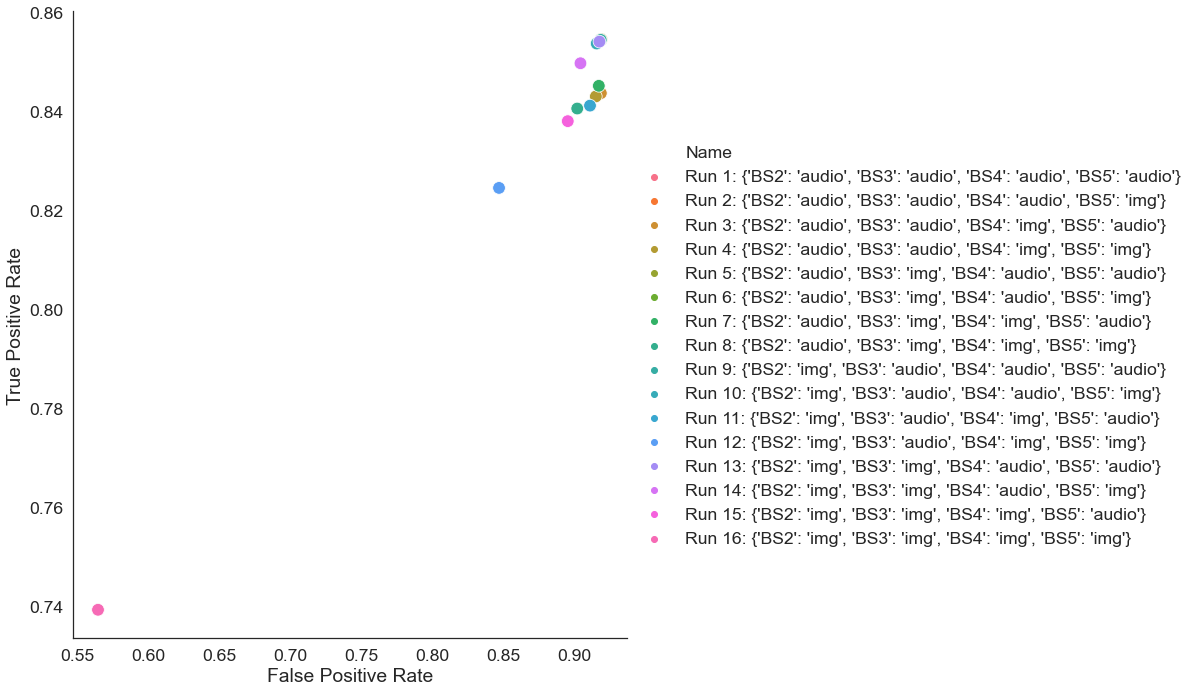

In [197]:
print(roc_df_filled)
ax = sns.relplot(x='False Positive Rate', y='True Positive Rate', data=roc_df_filled, hue='Name', kind='scatter', s=160, height=10, aspect=1)#, linewidth=0.05, height=8, aspect=3, s=30);
ax.savefig(f'/Users/maggie/Desktop/images_forQ9/relplot_summary_filled.png')


In [ ]:
ax = sns.relplot(x='False Positive Rate', y='True Positive Rate', data=df, hue='Run', kind='scatter', s=160, height=10, aspect=1)#, linewidth=0.05, height=8, aspect=3, s=30);

992


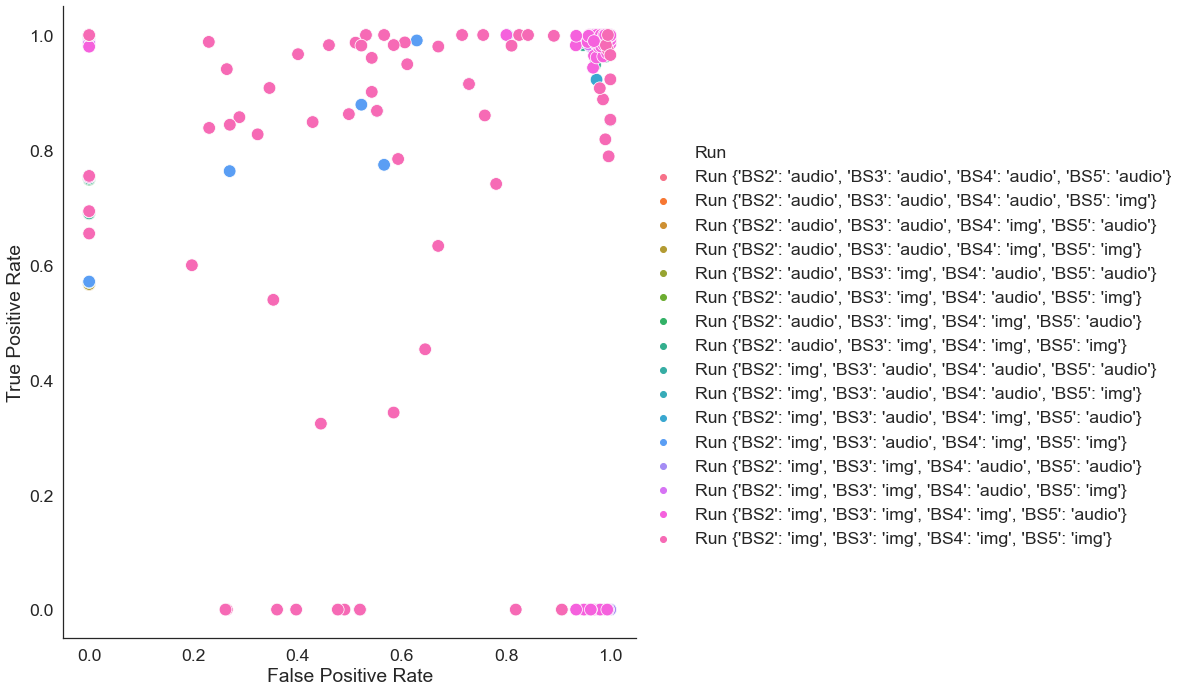

In [167]:
all_day_results = []

for x in all_instances_filled:
    RR = all_instances_filled[x].rate_results
    df = pd.DataFrame(RR)
    df['Run'] = f'Run {all_instances_filled[x].run_modalities}'
    all_day_results.append(df)

df = pd.concat(all_day_results)
df.rename(columns = {'FPR': 'False Positive Rate', 'TPR': 'True Positive Rate'}, inplace=True)



# df = df.loc[(df['True Positive Rate'] > 0.995) & (df['False Positive Rate'] < 0.005)]
print(len(df))



sns.set(font_scale=1.6, style='white')

ax = sns.relplot(x='False Positive Rate', y='True Positive Rate', data=df, hue='Run', kind='scatter', s=160, height=10, aspect=1)#, linewidth=0.05, height=8, aspect=3, s=30);
ax.savefig(f'/Users/maggie/Desktop/images_forQ9/relplot_16runs_filled.png')
# ax.set(xlim=(0.95, 1.01), ylim=(0.95, 1.01))



In [380]:
d = {'False Positive Rate': [], 'True Positive Rate': [], 'F1': [], 'Run': [], 'Inclusion': []}

for x in all_instances:
    d['False Positive Rate'].append(all_instances[x].FPR)
    d['True Positive Rate'].append(all_instances[x].TPR)
    d['Run'].append(str(x))
    d['Inclusion'].append(all_instances[x].spec)
    d['F1'].append(all_instances[x].f1)
print(d)
roc_df = pd.DataFrame(d)

roc_df.to_csv('/Users/maggie/Desktop/images_forQ9/Full_ROC_df.csv')

{'False Positive Rate': [0.9192064516129033, 0.9189483870967742, 0.9188177419354838, 0.9152903225806452, 0.9190725806451613, 0.9181145161290324, 0.9173790322580644, 0.9021177419354839, 0.9187225806451613, 0.9159048387096774, 0.9111677419354838, 0.8470806451612903, 0.9177758064516127, 0.9043967741935485, 0.8953822580645161, 0.5620532258064516], 'True Positive Rate': [0.8545129032258064, 0.8544048387096774, 0.842816129032258, 0.8417645161290324, 0.8544806451612904, 0.8538629032258064, 0.8421758064516129, 0.8334790322580645, 0.8544096774193548, 0.853466129032258, 0.8402064516129032, 0.818416129032258, 0.8538758064516129, 0.8468854838709677, 0.8291935483870968, 0.6402225806451614], 'Run': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16'], 'Inclusion': [['-1', '-1', '-1', '-1'], ['-1', '-1', '-1', '1'], ['-1', '-1', '1', '-1'], ['-1', '-1', '1', '1'], ['-1', '1', '-1', '-1'], ['-1', '1', '-1', '1'], ['-1', '1', '1', '-1'], ['-1', '1', '1', '1'], ['1', '

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize']=(18, 10)
sns.set()
sns.set_style("white")
sns.set_palette(sns.color_palette("deep"))

In [66]:
sns.set(font_scale=1.6, style='white')

ax = sns.relplot(x='False Positive Rate', y='True Positive Rate', data=df, hue='Run', kind='scatter', s=160, height=10, aspect=1)#, linewidth=0.05, height=8, aspect=3, s=30);
ax.savefig(f'/Users/maggie/Desktop/images_forQ9/for_presentation_1.png')

# ax.set(xlim=(0.95, 1.01), ylim=(0.95, 1.01))
# ax.set(xlim=(0.95, 1.015), ylim=(0.95, 1.015))

# plt.xlabel('Date', fontsize=24)
# plt.ylabel('CO2 Equivalent, ppm', fontsize=24)
# plt.title(name, fontsize=38)
# ax.savefig(f'/Users/maggie/Desktop/data_exploration_images/co2/{name}.png')   

NameError: name 'sns' is not defined